In [1]:
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set up

In [2]:
# set up auto load
%load_ext autoreload
%autoreload 2

In [3]:
from load_data import *
from model import *
plt.rcParams['font.family'] = 'serif'
sns.set_style("darkgrid")

In [4]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print('PyTorch CUDA is available?', torch.cuda.is_available())

PyTorch CUDA is available? True


# Get the training set
The training set is a combination of a list of tickers, see load_data.py for details. The training set must be shuffled (default) so that it can introduce randomness to data and can train the model better. look_back is a hyper-param and adjusting the look_back value may also need to adjust the learning rate.

In [5]:
train_ticker_strings = ["SPY", "AAPL", "TSLA", "META","ASG","KRT","RCFA","USCT", "AMZN"]
look_back = 60
train_data_loader = get_data_loader(PriceFeatureOnly, train_ticker_strings, look_back=look_back)
print("train data size (in batches):", len(train_data_loader))

train data size (in batches): 111


# Create the model.
Hyper-params can be adjusted.

In [6]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 1000
lr = 0.005
hist = np.zeros(num_epochs)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, device=device)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=lr)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


# Train the model

In [7]:

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    total_loss = 0
    y_train_preds = []
    for X_train, y_train in train_data_loader:

        # Forward pass
        y_train_pred = model(X_train)
        y_train_preds.extend(y_train_pred)

        loss = loss_fn(y_train_pred, y_train.to(device))

        total_loss += loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        # Update parameters
        optimiser.step()

    hist[t] = total_loss
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", total_loss)


Epoch  10 MSE:  0.6715790878515691
Epoch  20 MSE:  0.6626396125648171
Epoch  30 MSE:  0.6663974528200924
Epoch  40 MSE:  0.651450356701389
Epoch  50 MSE:  0.6589536303654313
Epoch  60 MSE:  0.6596502289175987
Epoch  70 MSE:  0.6547671984881163
Epoch  80 MSE:  0.6543992911465466
Epoch  90 MSE:  0.633716698968783
Epoch  100 MSE:  0.6246998533606529
Epoch  110 MSE:  0.6238281128462404
Epoch  120 MSE:  0.5880447330418974
Epoch  130 MSE:  0.5647182798711583
Epoch  140 MSE:  0.5493198399199173
Epoch  150 MSE:  0.5066511980257928
Epoch  160 MSE:  0.4822154054418206
Epoch  170 MSE:  0.4412253595655784
Epoch  180 MSE:  0.40611168777104467
Epoch  190 MSE:  0.37967893620952964
Epoch  200 MSE:  0.3674533342709765
Epoch  210 MSE:  3.9478747751563787
Epoch  220 MSE:  1.5891583473421633
Epoch  230 MSE:  1.6205732496455312
Epoch  240 MSE:  1.9553964571096003
Epoch  250 MSE:  1.686761346179992
Epoch  260 MSE:  1.518311911728233
Epoch  270 MSE:  1.3251371276564896
Epoch  280 MSE:  1.0917237889952958
Epo

# Plot the learning curve

Text(0.5, 1.0, 'Loss')

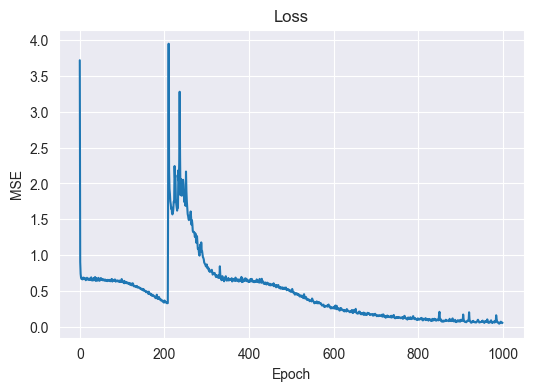

In [8]:
figure, axes = plt.subplots(figsize=(6, 4))
plt.plot(range(num_epochs), hist)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Loss")

# Prediction
Change the ticker name in test_ticker_string and run the rest of the cells to make a prediction on the given ticker. It can only predict one ticker at a time.

In [9]:
test_ticker_string = ['SNOW']
test_data_loader = get_data_loader(PriceFeatureOnly, test_ticker_string, look_back=look_back, shuffle=False, train=False)
predicted_ticker = test_ticker_string[0]
print("test data size (in batches):", len(test_data_loader))

test data size (in batches): 14


In [10]:
# make predictions
y_tests = []
y_test_preds = []
for X_test, y_test in test_data_loader:
    y_tests.extend(y_test)
    pred = model(X_test)
    y_test_preds.extend(pred)

y_tests = torch.stack(y_tests).cpu().detach().numpy()
y_test_preds = torch.stack(y_test_preds).cpu().detach().numpy()

# calculate root mean squared error
testScore = (mean_squared_error(y_tests[:,0], y_test_preds[:,0]))
print('Test Score: %.5f MSE' % (testScore))

y_tests = test_data_loader.dataset.invert_transform(y_tests)
y_test_preds = test_data_loader.dataset.invert_transform(y_test_preds)
test_price_score = np.sqrt(mean_squared_error(y_tests[:,0], y_test_preds[:,0]))
print('Test Price Score: %.2f RMSE' % (test_price_score))

Test Score: 0.00811 MSE
Test Price Score: 12.99 RMSE


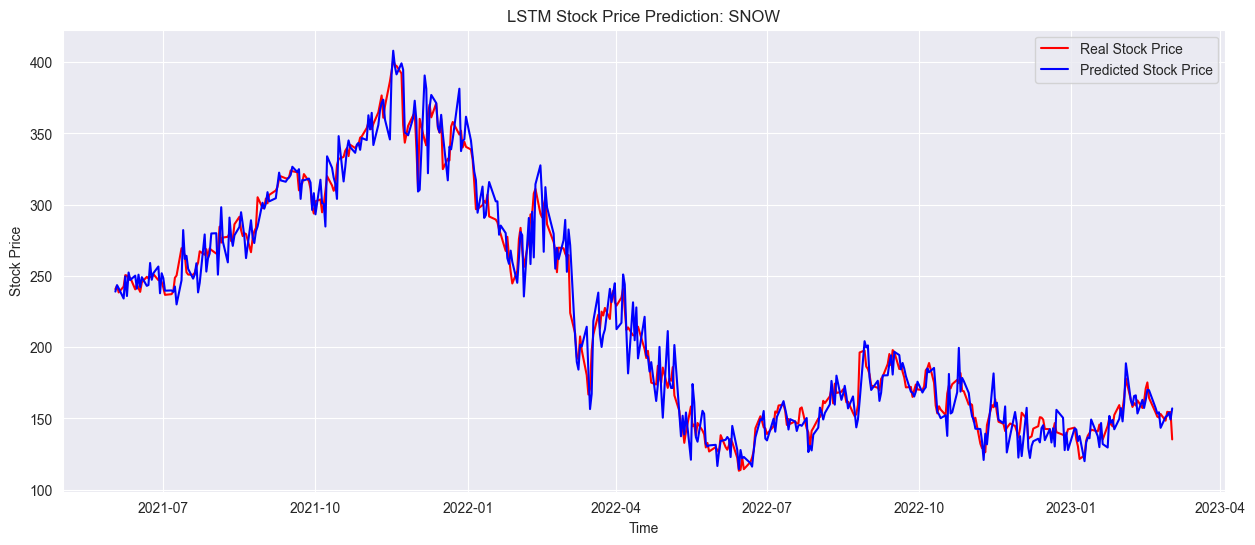

In [11]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

df = test_data_loader.dataset.df

axes.plot(df[look_back:].index, y_tests[:,0], color = 'red', label = 'Real Stock Price')
axes.plot(df[look_back:].index, y_test_preds[:,0], color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title(f'LSTM Stock Price Prediction: {predicted_ticker}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig(f'./plots/lstm_baseline_pred_{predicted_ticker}.png')
plt.show()